In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
plt.style.use('ggplot')
pd.set_option('display.max_rows', 1000)

ad = pd.read_csv('AllDeliveries.csv')
am = pd.read_csv('TableOfMatches.csv')
ap = pd.read_csv('AllPlayers.csv')
st = pd.read_stata('ScoreTallies.dta')
ad = ad.drop('Unnamed: 0',axis=1)
am = am.drop('Unnamed: 0',axis=1)

# Classes for Running Matches, Matches, Players and Strategies

## Player

In [2]:
class Player:
    def __init__(self,ProbArray,Name):
        self.ProbArray = ProbArray;
        self.Outcomes = [0,1,2,3,4,5,6,np.nan];
        self.LastInnings = [];
        self.Name = Name;
        
    def ProbVector(self,runrate):
        return self.ProbArray[:,runrate]
    
    def RunDelivery(self,runrate):
        return self.Outcomes[np.argmax(self.ProbArray[:,runrate].cumsum() > np.random.random())]
    
    def RunTillWicket(self,runrate):
        a = self.RunDelivery(runrate)
        l = []; n=0;
        while ~(np.isnan(a)) & (n<120):
            l.append(a);
            a = self.RunDelivery(runrate); n+=1;
        l.append(a);
        self.LastInnings = np.array(l);
        return l
    def StrikeRate(self,RunRate):
        ones = self.ProbVector(RunRate)[1]
        twos = self.ProbVector(RunRate)[2]
        threes = self.ProbVector(RunRate)[3]
        fours = self.ProbVector(RunRate)[4]
        fives = self.ProbVector(RunRate)[5]
        sixes = self.ProbVector(RunRate)[6]
        strikerate = ones+2*twos+3*threes+4*fours+5*fives+6*sixes;
        return strikerate

    def PlotPlayerData(self,Rates):
        ThePlayer = Match1.Players[0]
        [ThePlayer.ProbVector(i)[1] + ThePlayer.ProbVector(i) for i in Rates]
        aa = pd.DataFrame({'Rates':Rates,'WicketProbability':[self.ProbVector(i)[-1] for i in Rates],'StrikeRate':[6*self.StrikeRate(i) for i in Rates]})
        ax1 = sns.barplot(x='Rates',y='WicketProbability',data=aa,palette="GnBu_d")
        ax1.set_title("Wicket Probabilites for "+ self.Name)
        ax1.set_ylabel("Wicket Probability")
        plt.show()
        ax2 = sns.barplot(x='Rates',y='StrikeRate',data=aa,palette="GnBu_d")
        ax2.set_title("Expected Strike Rate for "+ self.Name)
        ax2.set_ylabel("Strike Rate")
        plt.show()

## Running a Match

In [3]:
def RunMatch(rrs,Players):
    Batsmen = [0,1];Next = 2; Innings=np.array([]);
    Scores = [0]*len(Players);
    for i in range(120):
        PlayerBatting = Players[Batsmen[0]];
        delOutcome = PlayerBatting.RunDelivery(rrs[Batsmen[0]]);
        if np.isnan(delOutcome):
            Batsmen[0] = Next;
            Next = Next + 1;
        else:
            Scores[Batsmen[0]] += delOutcome;
        if np.isin(delOutcome,[1,3,5]):
            Batsmen = [Batsmen[1],Batsmen[0]];
        Innings = np.append(Innings,delOutcome)
        if Next > 11:
            break
    return Innings,Scores

def RunMatchOptimized(rrs,Players):
    Batsmen = [0,1];Next = 2; runs=0;
    for i in range(120):
        PlayerBatting = Players[Batsmen[0]];
        delOutcome = PlayerBatting.RunDelivery(rrs[Batsmen[0]]);
        if np.isnan(delOutcome):
            Batsmen[0] = Next;
            Next = Next + 1;
        elif np.isin(delOutcome,[1,3,5]):
            Batsmen = [Batsmen[1],Batsmen[0]];
            runs = runs+delOutcome;
        else:
            runs = runs+delOutcome;
        if Next > 11:
            break
    return runs

## Match Class

In [4]:
class Match:
    def __init__(self,PlayerNames,Strategy):
        self.PlayerNames = PlayerNames;
        self.Target = 0;
        self.Distribution = [];
        self.Rates = [5]*11;
        self.Players = [plays[Playername] for Playername in PlayerNames];
        self.Strategy = Strategy
        
    def SetTarget(self,Target):
        self.Target = Target;
        
    def AssignRates(self,rrs):
        self.Rates = rrs;
        
    def RunMatchOptimized(self,Strategy,Players,Target):
        Batsmen = [0,1];Next = 2; runs=0;
        for i in range(120):
            PlayerBatting = Players[Batsmen[0]];
            RRR = int((Target-runs)*6/(120-i)); Over = i;
            rstrat = self.Strategy.Function(Batsmen[0],RRR,Over,runs);
            delOutcome = PlayerBatting.RunDelivery(rstrat);
            #print(rstrat)
            if np.isnan(delOutcome):
                Batsmen[0] = Next;
                Next = Next + 1;
            elif np.isin(delOutcome,[1,3,5]):
                Batsmen = [Batsmen[1],Batsmen[0]];
                runs = runs+delOutcome;
            else:
                runs = runs+delOutcome;
            if Next > 11:
                break
        return runs
    
    def RunMatch(self,Target):
        Batsmen = [0,1];Next = 2; runs=0;
        Required = []; Innings = []; Batsman = []; NonStriker = [];
        BatState = []; Score = [];
        for i in range(120):
            PlayerBatting = self.Players[Batsmen[0]]; 
            RRR = int((Target-runs)*6/(120-i)); Over = i;
            rstrat = self.Strategy.Function(Batsmen[0],RRR,Over,runs);
            Required.append(RRR); BatState.append(rstrat);
            delOutcome = PlayerBatting.RunDelivery(rstrat);
            if np.isnan(delOutcome):
                Batsmen[0] = Next;
                Next = Next + 1;
            elif np.isin(delOutcome,[1,3,5]):
                Batsmen = [Batsmen[1],Batsmen[0]];
                runs = runs+delOutcome;
            else:
                runs = runs+delOutcome;
            Innings.append(delOutcome); Batsman.append(PlayerBatting.Name);
            Score.append(runs)
            if Next > 11:
                break
        data = {'Outcome': Innings,'Score': Score,'Batsman': Batsman,'BatsmanState': BatState,'Required': Required}
        thing = pd.DataFrame(data)
        print(runs)
        return thing
        
    def RunMonteCarlo(self,NTrials,Target,Draw=False):
        self.Distribution = np.array([self.RunMatchOptimized(self.Rates,self.Players,Target) for i in range(NTrials)]);
        if Draw:
            plt.hist(self.Distribution,bins=15); 
            plt.xlabel('Runs'); plt.ylabel('Frequency');
            #p = WinProb(self.Target)
            plt.title('Distribution Of Scores',fontsize=18)
            plt.show();
        p = (self.Distribution > Target).sum()/len(self.Distribution);
        print(str(int(p*100)) + ' % probability of winning')
        return p
        
    def WinProb(self,Target):
        p = (self.Distribution > Target).sum()/len(self.Distribution);
        return p

## Strategy Functions

In [5]:
class Strategy:
    def __init__(self,BatsmanRates=[],RRR=[],Overs=[]):
        self.BatsmanRates = BatsmanRates
        self.BatsmanRates = self.BatsmanRates + [4]*(11-len(self.BatsmanRates))
        self.RRRCurve = RRR
        self.OverCurve = Overs
        self.Function = self.MixAgents([0,1,2])
    
    def BatsmanStrat(self,Batsman,RRR,Over,Runs):
        return self.BatsmanRates[Batsman]
    
    def RRRStrat(self,Batsman,RRR,Over,Runs):
        return self.RRRCurve[RRR]
    
    def OversStrat(self,Batsman,RRR,Over,Runs):
        return self.OverCurve[Over]
    
    def FreeAgents(self,Batsman,RRR,Over,Runs):
        a = np.max([np.min([RRR,18]),4])
        if (RRR*(120-Over)/6 < 30) and (a < 6):
            a = 6;
        return a
    
    def MixAgents(self,Fixed):
        def FixedFreeHybrid(Batsman,RRR,Over,Runs):
            if np.isin(Batsman,Fixed):
                return self.BatsmanRates[Batsman]
            else:
                return self.FreeAgents(Batsman,RRR,Over,Runs)
        return FixedFreeHybrid

# Probability Estimation from Data 

## Extracting a Prior 

In [6]:
#Data About Every Batsman's outcome count by Required Run Rate
final = pd.read_stata('merged.dta');
final['dels'] = final.dots_ + final.ones_ + final.twos_ + final.threes_ + final.fours_ + final.fives_ + final.sixes_ + final.out;

#Converting to Probability Ratios
ta = final[['batsman','rrr','dots_','ones_','twos_','threes_','fours_','fives_','sixes_','out','dels']]
tt = ta.groupby('rrr')['dots_','ones_','twos_','threes_','fours_','fives_','sixes_','out','dels'].sum().reset_index()

tt.dots_ = tt.dots_ / tt.dels;
tt.out = tt.out / tt.dels;
tt.ones_ = tt.ones_ / tt.dels;
tt.twos_ = tt.twos_ / tt.dels;
tt.threes_ = tt.threes_ / tt.dels;
tt.fours_ = tt.fours_ / tt.dels;
tt.fives_ = tt.fives_ / tt.dels;
tt.sixes_ = tt.sixes_/ tt.dels;

#Getting Probability Ratios average over every player & restricting to 0 < RunRate < 36
tk = tt[tt.rrr.between(0,36)].groupby('rrr')['dots_','ones_','twos_','threes_','fours_','fives_','sixes_','out','dels'].sum().reset_index()
p = tk.drop(['rrr','dels'],axis=1).values;

#p is our prior mean estimate for p

## Inferring Posterior Mean for Ball Outcome Probabilities

In [133]:
plays = {}; Nprev = 0; NOutcome = 8;
for j,aaa in ta.groupby('batsman'):
    x = np.zeros_like(p);
    th = p.copy();
    for i,row in aaa.iterrows():
        r = int(row['rrr']);
        if (r < 37) & (r > 0):
            x[r,:] = row[['dots_','ones_','twos_','threes_','fours_','fives_','sixes_','out']].values
            th[r,:] = (Nprev*p[r,:] + x[r,:])/(Nprev + int(row['dels']));
    plays[aaa['batsman'].iloc[0]] = Player(th.transpose(),aaa['batsman'].iloc[0])

c:\users\asad hussain\appdata\local\programs\python\python36-32\lib\site-packages\ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


## Running The Model For a Particular Team

In [46]:
#Choose A Team
India = ['S Dhawan','RG Sharma','V Kohli','Yuvraj Singh','MS Dhoni','SK Raina','RA Jadeja','R Ashwin','JJ Bumrah','B Kumar','A Nehra']

In [12]:
Match1.RunMatch(140) #One Simulated match for Target 140

161


,Batsman,BatsmanState,Outcome,Required,Score
0,S Dhawan,3,0.0,7,0
1,S Dhawan,3,1.0,7,1
2,RG Sharma,3,6.0,7,7
3,RG Sharma,3,4.0,6,11
4,RG Sharma,3,1.0,6,12
5,S Dhawan,3,1.0,6,13
6,RG Sharma,3,6.0,6,19
7,RG Sharma,3,0.0,6,19
8,RG Sharma,3,2.0,6,21
9,RG Sharma,3,0.0,6,21


In [54]:
NewStrat = Strategy([8,8,3]); NewStrat.Function = NewStrat.MixAgents([0,1,2]);
Match1 = Match(India,NewStrat);
%timeit Match1.RunMonteCarlo(1000,140);

64 % probability of winning
63 % probability of winning
65 % probability of winning
65 % probability of winning
1 loop, best of 3: 11 s per loop


## Running The Model For Different Strategies

In [515]:
import random
rates = [3,4,5,6,7,8,9,10,11,12,13,14];
result = np.zeros((15,15,15))
#indices = [(i,j,k) for j in rates for i in rates for k in rates]
indices = np.load('indices.npy');
indices = [tuple(indices[i]) for i,idd in enumerate(indices)]
Match1 = Match(India,NewStrat);
indicesused = []; answer = [];
for i in range(1000):
    a = random.choice(indices)
    indices.remove(a); print(a);
    NewStrat = Strategy([a[0],a[1],a[2]]); NewStrat.Function = NewStrat.MixAgents([0,1,2]);
    Match1.Strategy = NewStrat
    result[a] = Match1.RunMonteCarlo(1000,155)*100;
    indicesused.append(a); answer.append(result[a]);

(9, 5, 12)
16 % probability of winning
(12, 11, 6)
16 % probability of winning
(6, 5, 11)
7 % probability of winning
(9, 14, 3)
63 % probability of winning
(3, 14, 8)
31 % probability of winning
(6, 11, 9)
14 % probability of winning
(12, 11, 11)
13 % probability of winning
(3, 14, 5)
20 % probability of winning
(4, 3, 14)
22 % probability of winning
(5, 7, 3)
28 % probability of winning
(6, 8, 9)
15 % probability of winning
(10, 3, 13)
36 % probability of winning
(11, 4, 3)
31 % probability of winning
(3, 4, 12)
4 % probability of winning
(7, 10, 9)
7 % probability of winning
(9, 9, 13)
14 % probability of winning
(11, 3, 9)
36 % probability of winning
(3, 5, 8)
13 % probability of winning
(14, 10, 3)
40 % probability of winning
(8, 3, 12)
26 % probability of winning
(6, 12, 14)
50 % probability of winning
(10, 9, 12)
18 % probability of winning
(6, 4, 5)
5 % probability of winning
(3, 7, 11)
6 % probability of winning
(11, 10, 8)
20 % probability of winning
(3, 4, 13)
2 % probability

6 % probability of winning
(11, 9, 14)
7 % probability of winning
(14, 7, 5)
8 % probability of winning
(8, 9, 3)
35 % probability of winning
(9, 13, 11)
22 % probability of winning
(3, 9, 3)
34 % probability of winning
(14, 8, 10)
11 % probability of winning
(13, 6, 5)
11 % probability of winning
(10, 4, 5)
10 % probability of winning
(7, 12, 5)
55 % probability of winning
(12, 8, 5)
14 % probability of winning
(10, 3, 14)
36 % probability of winning
(14, 11, 7)
7 % probability of winning
(11, 11, 4)
6 % probability of winning
(7, 10, 11)
4 % probability of winning
(7, 4, 8)
12 % probability of winning
(5, 11, 3)
36 % probability of winning
(8, 8, 6)
11 % probability of winning
(4, 4, 4)
2 % probability of winning
(7, 12, 4)
39 % probability of winning
(6, 6, 11)
10 % probability of winning
(4, 12, 5)
53 % probability of winning
(9, 8, 3)
59 % probability of winning
(11, 4, 4)
3 % probability of winning
(8, 12, 7)
46 % probability of winning
(5, 8, 12)
10 % probability of winning
(3, 

53 % probability of winning
(10, 11, 7)
10 % probability of winning
(6, 11, 11)
9 % probability of winning
(6, 7, 5)
6 % probability of winning
(9, 7, 4)
9 % probability of winning
(5, 6, 11)
9 % probability of winning
(10, 12, 9)
71 % probability of winning
(6, 7, 12)
5 % probability of winning
(7, 11, 6)
15 % probability of winning
(12, 6, 3)
45 % probability of winning
(14, 11, 9)
16 % probability of winning
(13, 14, 14)
16 % probability of winning
(3, 6, 4)
3 % probability of winning
(7, 8, 14)
5 % probability of winning
(13, 7, 3)
38 % probability of winning
(14, 5, 10)
9 % probability of winning
(14, 3, 11)
34 % probability of winning
(9, 12, 14)
61 % probability of winning
(5, 6, 5)
6 % probability of winning
(4, 9, 12)
7 % probability of winning
(9, 8, 9)
27 % probability of winning
(5, 3, 3)
55 % probability of winning
(4, 7, 9)
7 % probability of winning
(7, 13, 13)
8 % probability of winning
(8, 10, 4)
4 % probability of winning
(11, 7, 5)
8 % probability of winning
(3, 10, 

IndexError: Cannot choose from an empty sequence

In [550]:
Results = pd.DataFrame({'Strategy':indicesused,'Win Probability': answer});
Resultdf = pd.DataFrame({'Strategy0':[i[0] for i in indicesused],'Strategy1': [i[1] for i in indicesused],'Strategy2':[i[2] for i in indicesused],'Win Probability': answer}); 
Results.to_csv('Results3140.csv'); Resultdf.to_csv('Resultsdf3140.csv');

In [514]:
Resultdf.to_csv('Resultsdf.csv');

In [446]:
np.save('indices.npy',indices)

In [143]:
a1=pd.read_csv('Resultsdf.csv').drop('Unnamed: 0',axis=1)
a2=pd.read_csv('Resultsdf3.csv').drop('Unnamed: 0',axis=1)

In [144]:
a3 = a1.append(a2)

In [148]:
a3.rename(index=str, columns={"Strategy0": "S Dhawan", "Strategy1": "RG Sharma","Strategy2":"V Kohli"}).sort_values(by='Win Probability',ascending=False)

,S Dhawan,RG Sharma,V Kohli,Win Probability
850,9,12,3,87.4
618,10,12,3,84.9
311,12,12,3,82.1
454,13,12,3,81.4
495,14,12,3,80.8
244,11,12,3,79.6
640,6,12,3,79.2
733,10,12,8,77.9
587,9,12,8,77.8
615,8,12,3,76.0


In [151]:
ss = a3[['Strategy0','Strategy1','Strategy2']].values
ssss = [tuple(ss[i]) for i,idd in enumerate(ss)]

In [152]:
res = np.zeros((15,15,15))
for ind in ssss:
    res[ind] = a3.loc[(a3.Strategy0 == ind[0]) & (a3.Strategy1 == ind[1]) & (a3.Strategy2 == ind[2]),'Win Probability'].values[0]

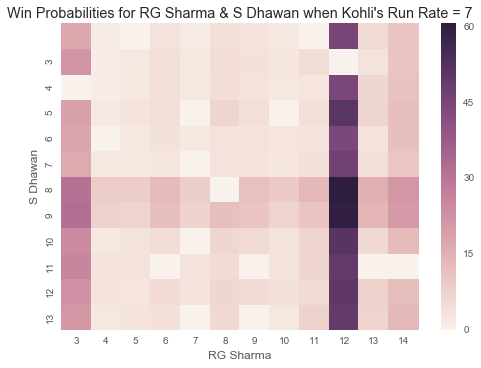

In [154]:
ax=sns.heatmap(res[3:,3:,7],xticklabels=list(range(3,15)),yticklabels=list(range(3,14)));
ax.set_xlabel(Match1.PlayerNames[1]);ax.set_ylabel(Match1.PlayerNames[0]);
plt.title("Win Probabilities for RG Sharma & S Dhawan when Kohli's Run Rate = 7")
plt.show()

In [548]:
result2 = result.copy()

In [142]:
Results.sort_values('Win Probability',ascending=False)

NameError: name 'Results' is not defined

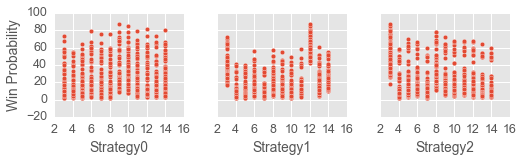

In [500]:
sns.pairplot(Resultdf,x_vars=['Strategy0','Strategy1','Strategy2'],y_vars='Win Probability');
plt.show()

## Plots for different players in a Match

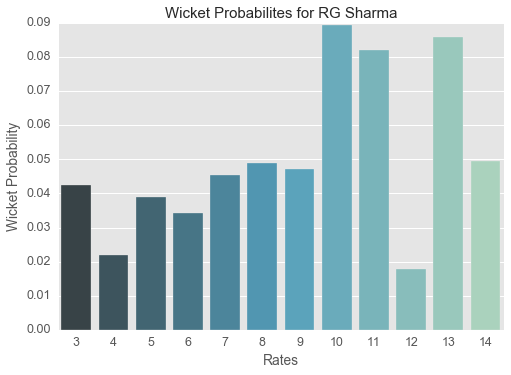

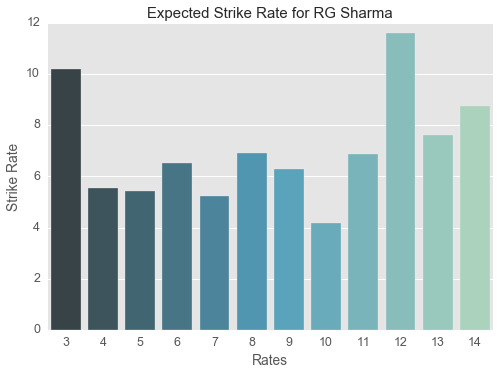

In [501]:
sns.set_context("notebook", font_scale=1.25)
Match1.Players[1].PlotPlayerData(list(range(3,15)))

In [413]:
mp = Match1.Players[0]
mp.ProbVector(12)

array([ 0.37661776,  0.36281276,  0.07247628,  0.00301984,  0.0811044 ,
        0.        ,  0.03753236,  0.06643658], dtype=float32)

## Premature Results

Giving the First & Second Batsman the same assigned rate

In [222]:
grap = pd.DataFrame({'RunRate':[3,4,5,6,7,8,9,10,11,12,13,14,15],'WinProbability':[51,16,18,28,17,28,46,35,34,81,34,46,55]})

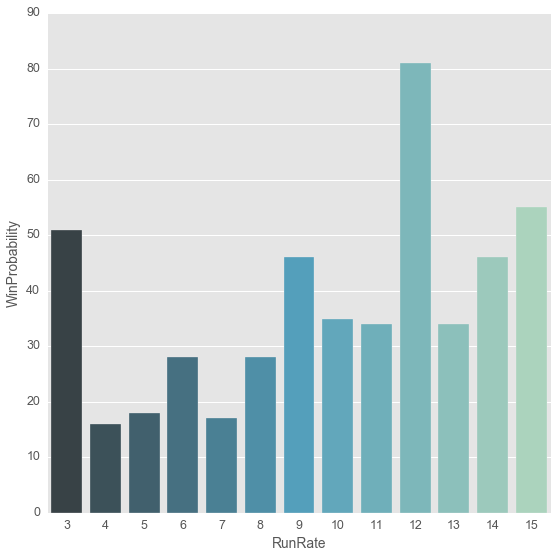

In [375]:
ax=sns.factorplot(x='RunRate',y='WinProbability',data=grap,kind='bar',palette="GnBu_d",size=8)
plt.show()

In [504]:
final.loc[final.batsman == 'RG Sharma',['batsman','rrr','dels']]

,batsman,rrr,dels
5154,RG Sharma,0.0,2.0
5155,RG Sharma,1.0,5.0
5156,RG Sharma,2.0,14.0
5157,RG Sharma,3.0,25.0
5158,RG Sharma,4.0,51.0
5159,RG Sharma,5.0,77.0
5160,RG Sharma,6.0,90.0
5161,RG Sharma,7.0,66.0
5162,RG Sharma,8.0,40.0
5163,RG Sharma,9.0,43.0


In [549]:
import random
rates = [3,4,5,6,7,8,9,10,11,12,13,14];
result = np.zeros((15,15,15))
indices = [(i,j,k) for j in rates for i in rates for k in rates]
#indices = np.load('indices.npy');
#indices= [tuple(indices[i]) for i,idd in enumerate(indices)]
Match1 = Match(India,NewStrat);
indicesused = []; answer = [];
for i in range(2000):
    a = random.choice(indices);
    indices.remove(a); print(a);
    NewStrat = Strategy([a[0],a[1],a[2]]); NewStrat.Function = NewStrat.MixAgents([0,1,2]);
    Match1.Strategy = NewStrat
    result[a] = Match1.RunMonteCarlo(1000,140)*100;
    indicesused.append(a); answer.append(result[a]);

(11, 3, 10)
59 % probability of winning
(14, 3, 7)
44 % probability of winning
(9, 13, 14)
39 % probability of winning
(14, 6, 6)
37 % probability of winning
(5, 14, 5)
42 % probability of winning
(4, 12, 4)
64 % probability of winning
(9, 8, 12)
44 % probability of winning
(4, 13, 4)
20 % probability of winning
(5, 13, 10)
31 % probability of winning
(7, 9, 10)
22 % probability of winning
(7, 4, 12)
14 % probability of winning
(7, 9, 12)
20 % probability of winning
(3, 14, 14)
30 % probability of winning
(9, 6, 6)
52 % probability of winning
(9, 13, 5)
51 % probability of winning
(9, 13, 8)
66 % probability of winning
(12, 5, 3)
60 % probability of winning
(10, 6, 14)
34 % probability of winning
(10, 5, 9)
40 % probability of winning
(12, 3, 4)
44 % probability of winning
(7, 5, 13)
11 % probability of winning
(4, 11, 5)
27 % probability of winning
(5, 11, 6)
33 % probability of winning
(6, 8, 8)
50 % probability of winning
(3, 12, 5)
76 % probability of winning
(8, 13, 3)
66 % probab

45 % probability of winning
(13, 12, 13)
71 % probability of winning
(4, 4, 3)
38 % probability of winning
(7, 3, 10)
49 % probability of winning
(9, 9, 3)
74 % probability of winning
(11, 6, 11)
33 % probability of winning
(11, 14, 6)
50 % probability of winning
(5, 11, 11)
28 % probability of winning
(5, 9, 6)
30 % probability of winning
(13, 6, 8)
51 % probability of winning
(6, 3, 9)
59 % probability of winning
(10, 6, 3)
73 % probability of winning
(14, 3, 8)
71 % probability of winning
(8, 8, 8)
47 % probability of winning
(9, 6, 9)
51 % probability of winning
(7, 10, 7)
9 % probability of winning
(7, 5, 7)
9 % probability of winning
(4, 10, 7)
11 % probability of winning
(4, 12, 9)
74 % probability of winning
(12, 11, 10)
34 % probability of winning
(12, 8, 8)
51 % probability of winning
(3, 4, 14)
11 % probability of winning
(3, 13, 5)
30 % probability of winning
(4, 5, 11)
22 % probability of winning
(13, 13, 13)
27 % probability of winning
(13, 6, 14)
25 % probability of winn

21 % probability of winning
(10, 12, 3)
93 % probability of winning
(10, 7, 9)
39 % probability of winning
(11, 11, 3)
72 % probability of winning
(6, 9, 7)
16 % probability of winning
(5, 6, 8)
42 % probability of winning
(10, 14, 11)
57 % probability of winning
(7, 7, 14)
11 % probability of winning
(10, 4, 5)
32 % probability of winning
(13, 10, 6)
31 % probability of winning
(13, 5, 14)
15 % probability of winning
(6, 3, 11)
56 % probability of winning
(4, 14, 8)
57 % probability of winning
(11, 8, 11)
35 % probability of winning
(13, 10, 13)
19 % probability of winning
(6, 13, 12)
27 % probability of winning
(7, 8, 4)
13 % probability of winning
(7, 6, 12)
22 % probability of winning
(10, 3, 8)
78 % probability of winning
(9, 10, 13)
28 % probability of winning
(3, 14, 6)
46 % probability of winning
(12, 5, 4)
16 % probability of winning
(6, 5, 8)
37 % probability of winning
(12, 3, 6)
61 % probability of winning
(9, 14, 7)
44 % probability of winning
(13, 5, 13)
16 % probability 

64 % probability of winning
(7, 14, 12)
35 % probability of winning
(3, 9, 9)
29 % probability of winning
(3, 6, 7)
14 % probability of winning
(12, 5, 5)
24 % probability of winning
(3, 4, 12)
15 % probability of winning
(7, 10, 12)
15 % probability of winning
(14, 11, 7)
19 % probability of winning
(10, 5, 8)
50 % probability of winning
(3, 8, 5)
28 % probability of winning
(6, 9, 11)
29 % probability of winning
(8, 11, 13)
22 % probability of winning
(12, 12, 5)
80 % probability of winning
(12, 4, 14)
15 % probability of winning
(9, 12, 14)
76 % probability of winning
(11, 9, 14)
23 % probability of winning
(10, 4, 7)
23 % probability of winning
(11, 7, 11)
25 % probability of winning
(3, 11, 10)
27 % probability of winning
(11, 3, 9)
62 % probability of winning
(10, 4, 14)
25 % probability of winning
(3, 14, 5)
37 % probability of winning
(3, 13, 4)
19 % probability of winning
(6, 13, 3)
71 % probability of winning
(8, 5, 3)
57 % probability of winning
(9, 7, 11)
37 % probability o

84 % probability of winning
(10, 9, 6)
48 % probability of winning
(14, 5, 5)
22 % probability of winning
(5, 8, 5)
29 % probability of winning
(10, 6, 8)
58 % probability of winning
(11, 4, 7)
13 % probability of winning
(4, 9, 5)
26 % probability of winning
(6, 6, 7)
16 % probability of winning
(3, 3, 4)
36 % probability of winning
(8, 11, 6)
30 % probability of winning
(9, 12, 9)
84 % probability of winning
(8, 7, 10)
20 % probability of winning
(11, 9, 13)
23 % probability of winning
(3, 6, 3)
59 % probability of winning
(3, 10, 8)
36 % probability of winning
(9, 14, 14)
49 % probability of winning
(12, 5, 11)
22 % probability of winning
(8, 5, 5)
20 % probability of winning
(6, 11, 7)
15 % probability of winning
(12, 14, 5)
48 % probability of winning
(4, 14, 14)
35 % probability of winning
(3, 12, 7)
65 % probability of winning
(4, 5, 4)
13 % probability of winning
(8, 3, 14)
46 % probability of winning
(3, 10, 10)
19 % probability of winning
(7, 12, 3)
88 % probability of winnin

49 % probability of winning
(11, 10, 8)
43 % probability of winning
(10, 6, 13)
36 % probability of winning
(10, 5, 10)
38 % probability of winning
(10, 8, 4)
35 % probability of winning
(14, 5, 8)
41 % probability of winning
(13, 11, 12)
29 % probability of winning
(6, 12, 7)
67 % probability of winning
(5, 12, 10)
73 % probability of winning
(4, 12, 13)
71 % probability of winning
(10, 7, 3)
70 % probability of winning
(13, 8, 10)
35 % probability of winning
(6, 11, 3)
66 % probability of winning
(10, 7, 8)
51 % probability of winning
(7, 3, 7)
34 % probability of winning
(9, 8, 10)
46 % probability of winning
(11, 10, 12)
19 % probability of winning
(8, 9, 3)
58 % probability of winning
(6, 10, 10)
23 % probability of winning
(14, 4, 12)
21 % probability of winning
(6, 13, 9)
38 % probability of winning
(5, 3, 8)
68 % probability of winning
(12, 3, 11)
60 % probability of winning
(11, 8, 7)
22 % probability of winning
(8, 11, 8)
46 % probability of winning
(5, 3, 9)
56 % probability

45 % probability of winning
(8, 9, 5)
25 % probability of winning
(4, 5, 14)
16 % probability of winning
(7, 11, 9)
30 % probability of winning
(5, 10, 12)
19 % probability of winning
(13, 7, 14)
17 % probability of winning
(13, 4, 5)
23 % probability of winning
(6, 10, 5)
23 % probability of winning
(14, 8, 7)
20 % probability of winning
(5, 7, 12)
19 % probability of winning
(13, 13, 8)
56 % probability of winning
(4, 5, 12)
21 % probability of winning
(9, 6, 7)
31 % probability of winning
(8, 9, 13)
19 % probability of winning
(4, 3, 3)
76 % probability of winning
(13, 9, 6)
36 % probability of winning
(14, 9, 6)
34 % probability of winning
(14, 14, 8)
64 % probability of winning
(4, 8, 6)
32 % probability of winning
(7, 8, 8)
46 % probability of winning
(6, 11, 13)
21 % probability of winning
(8, 7, 9)
23 % probability of winning
(13, 14, 4)
33 % probability of winning
(13, 12, 6)
84 % probability of winning
(12, 4, 7)
13 % probability of winning
(13, 3, 13)
46 % probability of win

15 % probability of winning
(11, 7, 6)
31 % probability of winning
(6, 12, 9)
78 % probability of winning
(11, 7, 5)
24 % probability of winning
(3, 4, 8)
28 % probability of winning
(13, 3, 10)
59 % probability of winning
(14, 12, 7)
69 % probability of winning
(12, 12, 11)
78 % probability of winning
(4, 12, 5)
71 % probability of winning
(6, 9, 12)
26 % probability of winning
(3, 5, 7)
9 % probability of winning
(11, 7, 7)
12 % probability of winning
(12, 5, 7)
13 % probability of winning
(9, 13, 6)
53 % probability of winning
(5, 5, 3)
52 % probability of winning
(3, 7, 7)
9 % probability of winning
(3, 6, 5)
25 % probability of winning
(7, 8, 6)
34 % probability of winning
(13, 12, 14)
71 % probability of winning
(3, 9, 14)
18 % probability of winning
(8, 10, 3)
57 % probability of winning
(3, 3, 11)
50 % probability of winning
(3, 8, 7)
15 % probability of winning
(4, 3, 6)
56 % probability of winning
(3, 3, 5)
50 % probability of winning
(3, 8, 9)
31 % probability of winning
(12

19 % probability of winning
(9, 14, 10)
60 % probability of winning
(8, 6, 4)
15 % probability of winning
(7, 7, 7)
9 % probability of winning
(6, 6, 10)
30 % probability of winning
(7, 14, 4)
25 % probability of winning
(4, 4, 10)
16 % probability of winning
(5, 7, 8)
37 % probability of winning
(10, 8, 9)
53 % probability of winning
(5, 12, 8)
82 % probability of winning
(7, 5, 14)
12 % probability of winning
(9, 10, 3)
72 % probability of winning
(11, 11, 11)
35 % probability of winning
(14, 13, 3)
72 % probability of winning
(10, 8, 10)
47 % probability of winning
(3, 3, 8)
66 % probability of winning
(6, 11, 8)
51 % probability of winning
(5, 8, 12)
28 % probability of winning
(6, 6, 3)
65 % probability of winning
(13, 11, 6)
39 % probability of winning
(7, 14, 8)
54 % probability of winning
(13, 6, 3)
68 % probability of winning
(6, 14, 8)
59 % probability of winning
(6, 5, 5)
22 % probability of winning
(14, 9, 10)
29 % probability of winning
(13, 3, 3)
83 % probability of winni

IndexError: Cannot choose from an empty sequence

In [555]:
Resultdf

,Strategy0,Strategy1,Strategy2,Win Probability
0,11,3,10,59.3
1,14,3,7,44.4
2,9,13,14,39.3
3,14,6,6,37.1
4,5,14,5,42.1
5,4,12,4,64.9
6,9,8,12,44.5
7,4,13,4,20.2
8,5,13,10,31.2
9,7,9,10,22.8


In [17]:
Match1.RunMatch(130)

123


,Batsman,BatsmanState,Outcome,Required,Score
0,S Dhawan,6,0.0,6,0
1,S Dhawan,6,0.0,6,0
2,S Dhawan,6,NaN,6,0
3,V Kohli,6,2.0,6,2
4,V Kohli,6,0.0,6,2
5,V Kohli,6,1.0,6,3
6,RG Sharma,6,0.0,6,3
7,RG Sharma,6,1.0,6,4
8,V Kohli,6,0.0,6,4
9,V Kohli,6,1.0,6,5


In [79]:
ad[(ad.BattingTeam == 'India') & (ad.Innings == 2)].groupby('InningsId').first().reset_index()[['Target','BattingTeamWon','Winner']]

,Target,BattingTeamWon,Winner
0,171.0,False,Zimbabwe
1,100.0,True,India
2,246.0,False,West Indies
3,144.0,False,no result
4,127.0,True,India
5,191.0,False,New Zealand
6,167.0,True,India
7,113.0,True,India
8,154.0,False,England
9,131.0,False,South Africa


In [24]:
ad[(ad.BattingTeam == 'India') & (ad.Innings == 2) & (ad.InningsId == 41)]

,Innings,Delivery,Batsman,Bowler,Runs,NonStriker,Extras,Wicket,Fielder,PlayerOut,...,RequiredRR,CurrentRR,LegalDeliveries,Bowling style,Legal,BowlingTeam,BatsmanBalls,Winner,BattingTeamWon,RRR
4860,2,0.1,RG Sharma,AD Russell,2,AM Rahane,0,NaN,NaN,NaN,...,12.302521,12.000000,1.0,Right-arm Fast,True,West Indies,1.0,West Indies,False,12.300000
4861,2,0.2,RG Sharma,AD Russell,1,AM Rahane,0,NaN,NaN,NaN,...,12.355932,9.000000,2.0,Right-arm Fast,True,West Indies,2.0,West Indies,False,12.302521
4862,2,0.3,AM Rahane,AD Russell,1,RG Sharma,0,NaN,NaN,NaN,...,12.410256,8.000000,3.0,Right-arm Fast,True,West Indies,1.0,West Indies,False,12.355932
4863,2,0.4,RG Sharma,AD Russell,1,AM Rahane,0,NaN,NaN,NaN,...,12.465517,7.500000,4.0,Right-arm Fast,True,West Indies,3.0,West Indies,False,12.410256
4864,2,0.5,AM Rahane,AD Russell,0,RG Sharma,0,NaN,NaN,NaN,...,12.573913,6.000000,5.0,Right-arm Fast,True,West Indies,2.0,West Indies,False,12.465517
4865,2,0.6,AM Rahane,AD Russell,0,RG Sharma,0,NaN,NaN,NaN,...,12.684211,5.000000,6.0,Right-arm Fast,True,West Indies,3.0,West Indies,False,12.573913
4866,2,1.1,RG Sharma,S Badree,0,AM Rahane,0,NaN,NaN,NaN,...,12.796460,4.285714,7.0,Legbreak,True,West Indies,4.0,West Indies,False,12.684211
4867,2,1.2,RG Sharma,S Badree,4,AM Rahane,0,NaN,NaN,NaN,...,12.696429,6.750000,8.0,Legbreak,True,West Indies,5.0,West Indies,False,12.796460
4868,2,1.3,RG Sharma,S Badree,4,AM Rahane,0,NaN,NaN,NaN,...,12.594595,8.666667,9.0,Legbreak,True,West Indies,6.0,West Indies,False,12.696429
4869,2,1.4,RG Sharma,S Badree,1,AM Rahane,0,NaN,NaN,NaN,...,12.654545,8.400000,10.0,Legbreak,True,West Indies,7.0,West Indies,False,12.594595


In [55]:
predictions = [Match1.RunMonteCarlo(300,target) for target in tars.Target.values]

12 % probability of winning
99 % probability of winning
0 % probability of winning
54 % probability of winning
81 % probability of winning
4 % probability of winning
18 % probability of winning
94 % probability of winning
43 % probability of winning
76 % probability of winning
17 % probability of winning
93 % probability of winning
6 % probability of winning
19 % probability of winning
0 % probability of winning
0 % probability of winning
94 % probability of winning
63 % probability of winning
17 % probability of winning
75 % probability of winning
78 % probability of winning
0 % probability of winning
35 % probability of winning
25 % probability of winning
0 % probability of winning
9 % probability of winning
72 % probability of winning
83 % probability of winning
66 % probability of winning
14 % probability of winning
51 % probability of winning
1 % probability of winning
81 % probability of winning
86 % probability of winning
31 % probability of winning
100 % probability of winning


In [ ]:
ak = tars.join(pd.DataFrame(np.array(predictions) > 0.5))

In [155]:
ak[ak[0]==ak.BattingTeamWon].count() #=28

Target            28
BattingTeamWon    28
0                 28
dtype: int64

In [158]:
Accuracy = 28*100/40
print("Accuracy is " + str(Accuracy) + "%")

Accuracy is 70.0%


In [124]:
avgg = final.groupby(['rrr'])['dots_','ones_','twos_','threes_','fours_','fives_','sixes_','out'].sum().reset_index()

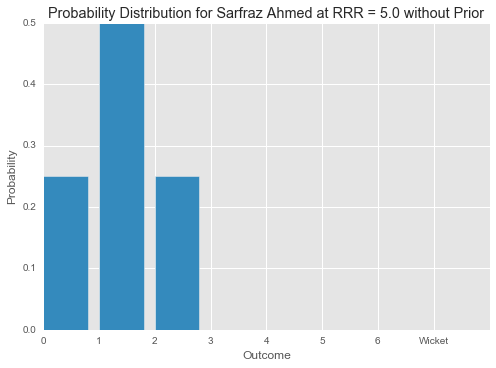

In [141]:
mohm = plays['Sarfraz Ahmed'];
x = [0,1,2,3,4,5,6,7];
plt.bar(x,mohm.ProbArray[:,5]); 
plt.xticks(x, (0,1,2,3,4,5,6,'Wicket'));
plt.xlabel('Outcome'); plt.ylabel('Probability')
plt.title("Probability Distribution for Sarfraz Ahmed at RRR = 5.0 without Prior")
plt.show()